<h1>Environment</h1>

Verify that we have the correct version of astropy:

In [1]:
import astropy
print(astropy.__version__)

3.2.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import astropy.units as u

<h1>Data input</h1>

Begin by importing the helper functions in the 'proto' package:

In [3]:
import fit_functions
from specutils import Spectrum1D, SpectralRegion

Read data files: 
 - spectrum: simple 3-column ASCII file
 - wavelength regions to be included in fit: simple 2-column ASCII file

In [4]:
datafile = "../data/n5548/n5548_mean_g130mb4.asc"
regionsfile = "../data/n5548/n5548_lyalpha_sample.dat"

The read_file function reads the spectrum file and an optional regions file. 

Spectrum is returned as a Spectrum1D instance that encapsulates wavelength, flux, and error arrays. 

Regions is a list of SpectralRegion instances, one per region in the regions file.

Mask is a float numpy array with 1's for data points in regions and 0's for data points outside regions.

In [5]:
spectrum, regions, line_mask = fit_functions.read_file(datafile, regions=regionsfile)

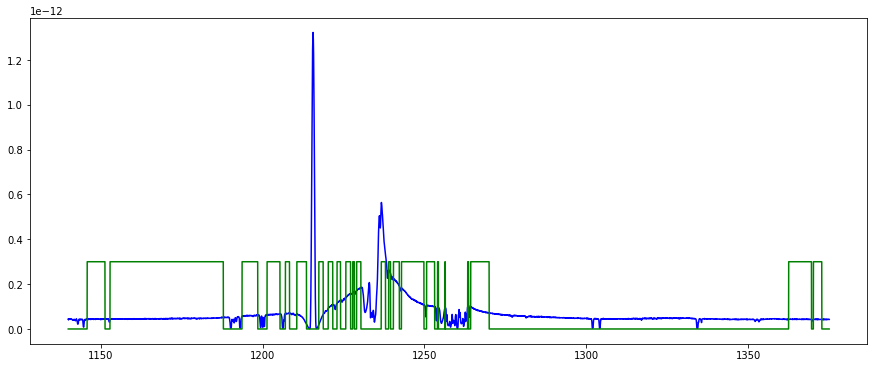

In [6]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, line_mask*3.E-13, 'g')

<h1>Fitting</h1>

Start by building a compound model to act as first guess (this is explained in notebook specfit_demo_specutils.ipynb).

In [7]:
import n5548_models_specfit as models
compound_model = models.model1

print(compound_model)

Model: CompoundModel19
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16] + [17] + [18] + [19] + [20]
Components: 
    [0]: <PowerLaw1D(amplitude=0., x_0=1000., alpha=0.4819233)>

    [1]: <Gaussian1D(amplitude=0., mean=1195.006, stddev=1.45817626)>

    [2]: <Gaussian1D(amplitude=0., mean=1226.392, stddev=1.49647424)>

    [3]: <Gaussian1D(amplitude=0., mean=1236.729, stddev=0.4475623)>

    [4]: <Gaussian1D(amplitude=0., mean=1235.996, stddev=1.50819328)>

    [5]: <Gaussian1D(amplitude=0., mean=1235.138, stddev=5.31938877)>

    [6]: <Gaussian1D(amplitude=0., mean=1231.589, stddev=14.1876428)>

    [7]: <Gaussian1D(amplitude=0., mean=1237.643, stddev=31.8761801)>

    [8]: <Gaussian1D(amplitude=0., mean=1259.753, stddev=0.4558945)>

    [9]: <Gaussian1D(amplitude=0., mean=1263.803, stddev=0.45736016)>

    [10]: <Gaussian1D(amplitude=0., mean=1259.533, stddev=1.536913

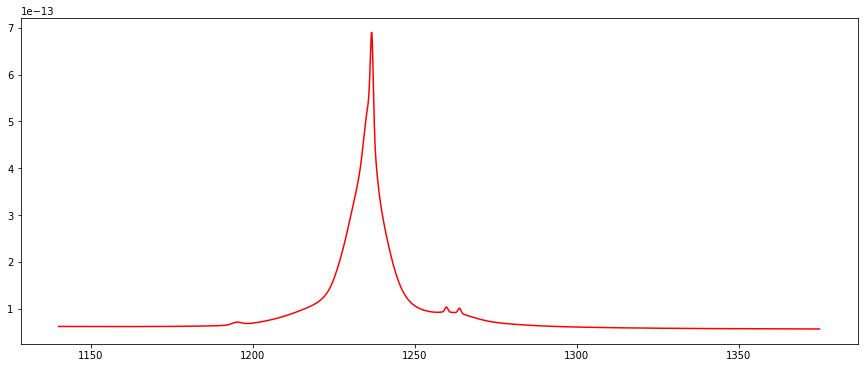

In [8]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')

The actual fitting then is carried out by the fit_lines function.

In [9]:
import astropy.modeling.fitting as fitting
from specutils.fitting import fit_lines
import time

# weight array contains both mask and uncertainties
w = line_mask.copy()
w /= spectrum.uncertainty.array
max_w = np.max(w)
w /= max_w

start_time = time.time()

# pass an explicit fitter so we can check for diagnostics
fitter = fitting.LevMarLSQFitter()
fit_result = fit_lines(spectrum, compound_model, fitter=fitter, weights=w, maxiter=1000)

end_time = time.time()

print(end_time - start_time)

5.076869964599609


In [10]:
print(fitter.fit_info['message'])

Number of calls to function has reached maxfev = 1000.


The result is an instance of QuantityModel. We use it's unitless version:

In [11]:
print(fit_result.unitless_model)

Model: CompoundModel39
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16] + [17] + [18] + [19] + [20]
Components: 
    [0]: <PowerLaw1D(amplitude=0., x_0=1000., alpha=0.4819233)>

    [1]: <Gaussian1D(amplitude=0., mean=1195.006, stddev=1.45817626)>

    [2]: <Gaussian1D(amplitude=0., mean=1226.392, stddev=1.49647424)>

    [3]: <Gaussian1D(amplitude=0., mean=1236.729, stddev=0.4475623)>

    [4]: <Gaussian1D(amplitude=0., mean=1235.996, stddev=1.50819328)>

    [5]: <Gaussian1D(amplitude=0., mean=1235.138, stddev=5.31938877)>

    [6]: <Gaussian1D(amplitude=0., mean=1231.589, stddev=14.1876428)>

    [7]: <Gaussian1D(amplitude=0., mean=1237.643, stddev=31.8761801)>

    [8]: <Gaussian1D(amplitude=0., mean=1259.753, stddev=0.4558945)>

    [9]: <Gaussian1D(amplitude=0., mean=1263.803, stddev=0.45736016)>

    [10]: <Gaussian1D(amplitude=0., mean=1259.533, stddev=1.536913

<h1>Plot fit results</h1>

<h3>Input and output compound models</h3>

In [12]:
fit_result = fit_result.unitless_model

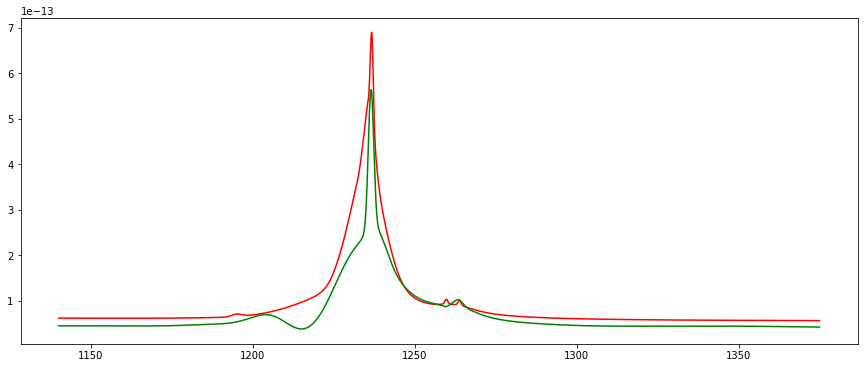

In [13]:
plt.gcf().set_size_inches(15.,6.)
plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')
fitted_spectrum = fit_result(spectrum.spectral_axis.data)
plt.plot(spectrum.spectral_axis.data, fitted_spectrum, 'g')

<h3>Input compound model ("first guess") overploted on input spectrum</h3>

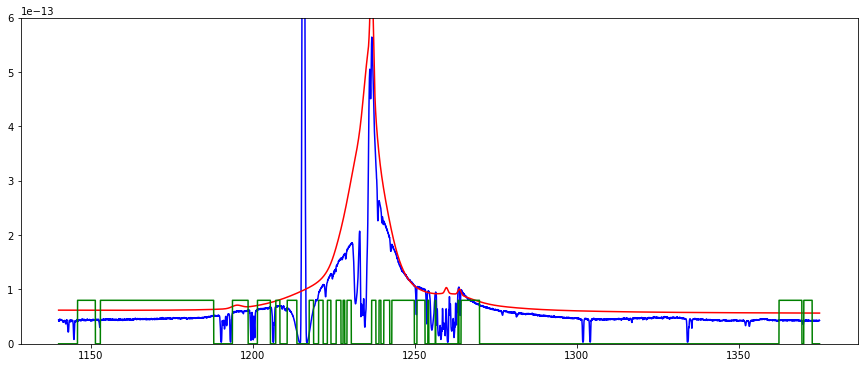

In [14]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, compound_model(spectrum.spectral_axis.data), 'r')
plt.plot(spectrum.spectral_axis.data, line_mask*8.E-14, 'g')

<h3>Fit result overploted on input spectrum</h3>

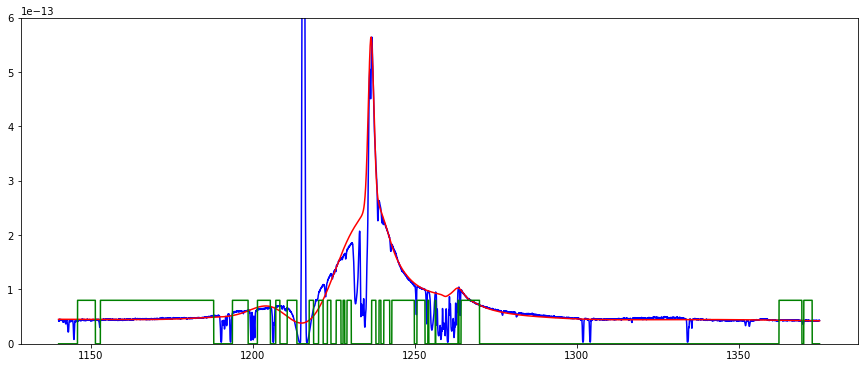

In [15]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(0., 6.e-13)
plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
plt.plot(spectrum.spectral_axis.data, fitted_spectrum, 'r')
plt.plot(spectrum.spectral_axis.data, line_mask*8.E-14, 'g')

<h3>Residuals</h3>

- YELLOW: input spectrum - input model
- BLUE: input spectrum - fitted model

In [16]:
residuals = spectrum.flux.data - fitted_spectrum
original_residuals = spectrum.flux.data - compound_model(spectrum.spectral_axis.data)

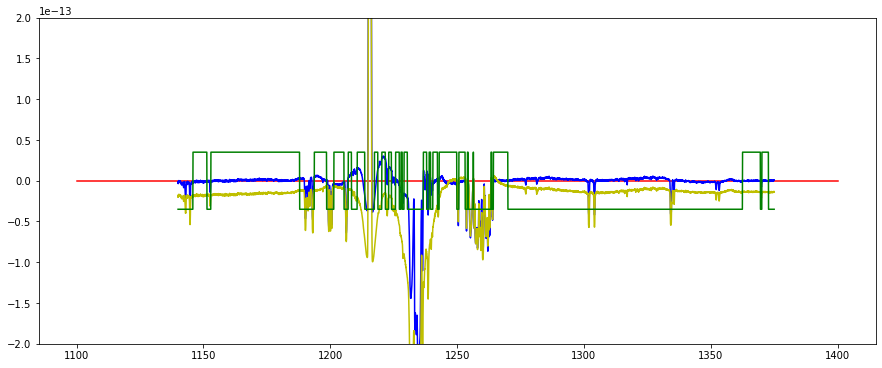

In [17]:
plt.gcf().set_size_inches(15.,6.)
plt.ylim(-2.e-13, 2.e-13)
plt.plot([1100., 1400], [0., 0.], 'r')
plt.plot(spectrum.spectral_axis.data, residuals, 'b')
plt.plot(spectrum.spectral_axis.data, original_residuals, 'y')
plt.plot(spectrum.spectral_axis.data, (line_mask-0.5)*7.E-14, 'g')

<h3>Detail of residuals plot</h3>

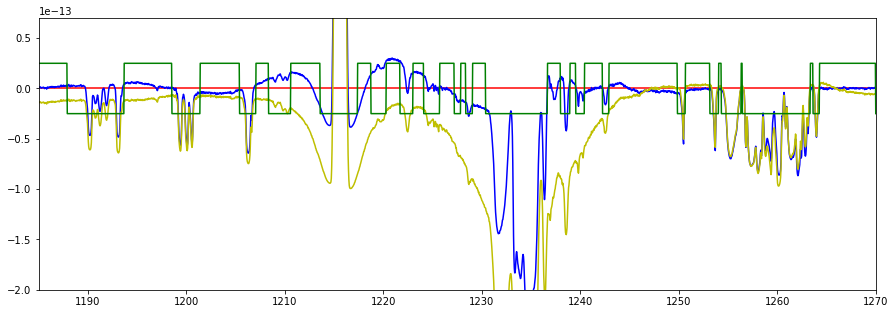

In [18]:
plt.gcf().set_size_inches(15.,5.)
plt.xlim(1185., 1270.)
plt.ylim(-2.e-13, 0.7e-13)
plt.plot([1185., 1270], [0., 0.], 'r')
plt.plot(spectrum.spectral_axis.data, residuals, 'b')
plt.plot(spectrum.spectral_axis.data, original_residuals, 'y')
plt.plot(spectrum.spectral_axis.data, (line_mask-0.5)*5.E-14, 'g')

<h1>Line finding</h1>

The spectrum carries an uncertainity attribute derived from the errors (defined in the input file). The line finder functions could use that transparently, but for illustration purposes, we supply then with a noise level cderived from a featureless continuum region. The operation below replaces the internal uncertainty attribute by a new one derived from the specified region.

In [19]:
from specutils.manipulation import noise_region_uncertainty

noise_region = SpectralRegion(1155*u.AA, 1185*u.AA)
spectrum = noise_region_uncertainty(spectrum, noise_region)

Line finding functions must be supplied with a continuum-subtracted version of the input spectrum. We build a simple realization of that, for demo purposes, by using the residuals as the input spectrum for the line finders.

In [20]:
from astropy.units import Quantity

flux = Quantity(residuals, spectrum.flux.unit)
sps = Spectrum1D(flux=flux, spectral_axis=spectrum.spectral_axis, uncertainty=spectrum.uncertainty)

Now, find lines using threshold and derivative methods:

In [21]:
from specutils.fitting import find_lines_threshold, find_lines_derivative

# detection sensitivity seems to depend on the noise level in a funny way. 
# There seems tro be an optimal level that detects a maximum of lines. 
# Values above and below that level detect less lines.

NOISE = 30
lines_t = find_lines_threshold(sps, noise_factor=NOISE)

# detection is *very* sensitive to the derivative threshold level
D_THRESH = 3.E-14
lines_d = find_lines_derivative(sps, flux_threshold=D_THRESH)

In [22]:
print(lines_t)

line_center line_type  line_center_index
  Angstrom                              
----------- ---------- -----------------
 1215.61899   emission              1949
 1190.20425 absorption              1294
 1193.11434 absorption              1369
 1199.40012 absorption              1531
 1200.09854 absorption              1549
 1200.56415 absorption              1561
 1206.30672 absorption              1709
 1216.70542 absorption              1977
 1231.72146 absorption              2364
 1234.94195 absorption              2447
        ...        ...               ...
 1259.38666 absorption              3077
 1260.20149 absorption              3098
 1260.86111 absorption              3115
 1262.10274 absorption              3147
 1262.87876 absorption              3167
 1263.15037 absorption              3174
   1264.004 absorption              3196
  1301.9903 absorption              4175
 1304.16316 absorption              4231
 1334.31164 absorption              5008
Length = 27 rows

In [23]:
print(lines_d)

line_center line_type  line_center_index
  Angstrom                              
----------- ---------- -----------------
 1215.58019   emission              1948
 1220.89594   emission              2085
 1144.69053 absorption               121
 1190.20425 absorption              1294
 1193.07554 absorption              1368
 1199.40012 absorption              1531
 1200.05974 absorption              1548
 1200.56415 absorption              1561
 1206.26792 absorption              1708
 1214.53256 absorption              1921
        ...        ...               ...
 1260.86111 absorption              3115
 1261.40432 absorption              3129
 1262.10274 absorption              3147
 1262.45195 absorption              3156
 1262.83996 absorption              3166
 1263.11157 absorption              3173
  1263.9652 absorption              3195
  1301.9127 absorption              4173
 1304.16316 absorption              4231
 1334.23404 absorption              5006
Length = 37 rows

Define a plotting convenience function:

In [24]:
def plot_helper(w1, w2, f1=-0.05E-12, f2=1.3E-12):
    plt.gcf().set_size_inches(15.,6.)
    plt.axis([w1, w2, f1, f2])
    plt.plot(spectrum.spectral_axis.data, spectrum.flux.data, 'b')
#     plt.plot(spectrum.spectral_axis.data, line_mask*0.3*f2, 'g')

    # noise region
    plt.plot(np.array([noise_region.lower.value, noise_region.upper.value]), np.array([0.2*f2,0.2*f2]), 'magenta')

    # found lines
    marker_style_t = dict(marker='|', color='red', s=5000)     # threshold in red
    marker_style_d = dict(marker='|', color='magenta', s=5000) # derivative in magenta
    plt.scatter(lines_t['line_center'], (np.ones(len(lines_t['line_center']))*0.8*f2), **marker_style_t)
    plt.scatter(lines_d['line_center'], (np.ones(len(lines_d['line_center']))*0.5*f2), **marker_style_d)

- RED: threshold method.
- MAGENTA: derivative method.

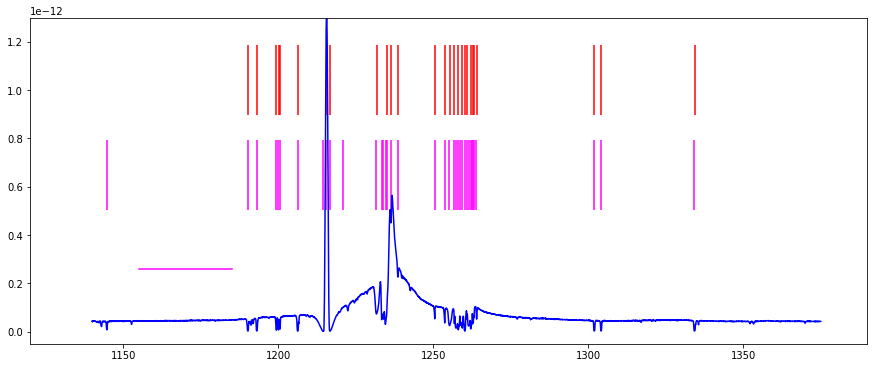

In [25]:
plot_helper(1120., 1390.)

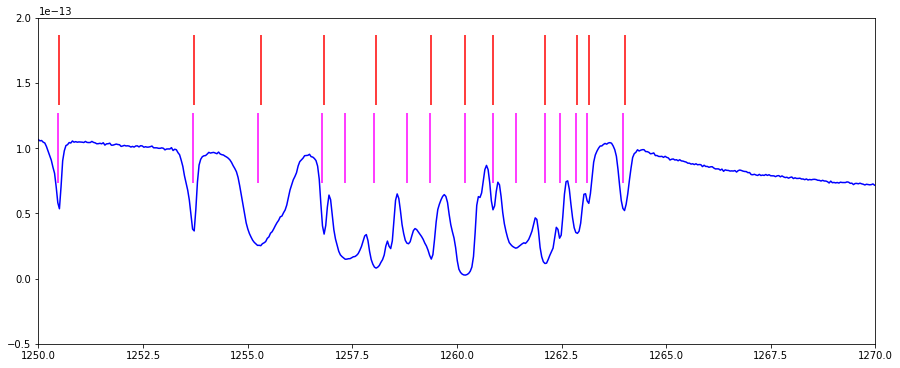

In [26]:
plot_helper(1250., 1270., f1=-0.05E-12, f2=2.E-13)

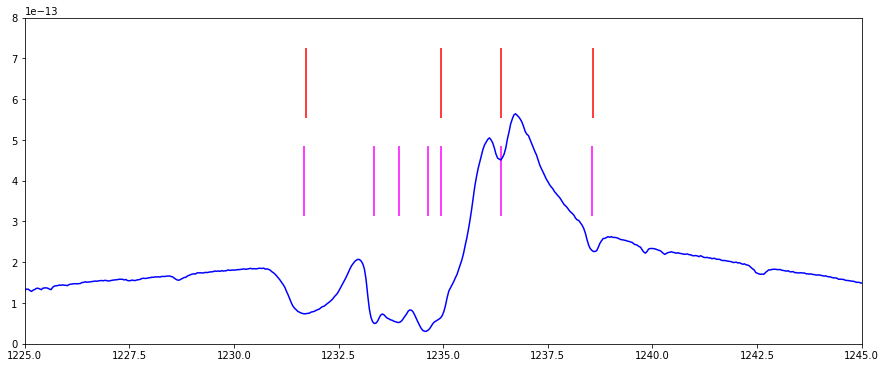

In [27]:
plot_helper(1225., 1245., f1=-0., f2=8.E-13)

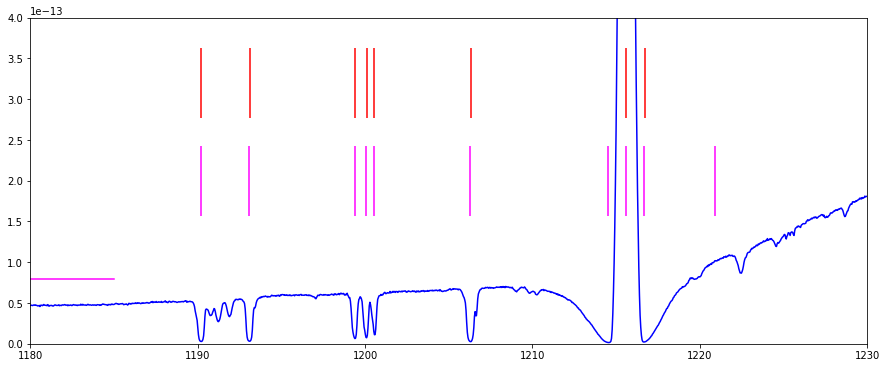

In [28]:
plot_helper(1180., 1230., f1=-0., f2=4.E-13)